# **Implementing Word2Vec with Logistic Regression and LSTM**

**CBOW (Continuous Bag-of-Words)** and **Skip-gram** are two popular algorithms used in natural language processing for generating word embeddings.

CBOW is a method that predicts the target word based on its context, which is a window of surrounding words. The goal of CBOW is to maximize the probability of predicting the target word given its context. In other words, CBOW learns to predict a word based on the words that surround it.

On the other hand, Skip-gram is the inverse of CBOW, where the algorithm predicts the context words given the target word. The goal of Skip-gram is to maximize the probability of predicting the context words given the target word.

The difference between CBOW and Skip-gram lies in their training objectives. CBOW is faster to train than Skip-gram because it involves predicting one target word from multiple context words, whereas Skip-gram predicts multiple context words from one target word. However, **Skip-gram is better at capturing rare and infrequent words, while CBOW is better at representing the overall meaning of a sentence**.

In summary, CBOW is a faster algorithm that predicts a target word based on its context, while Skip-gram is slower but better at capturing rare words by predicting context words given a target word. The choice of which algorithm to use depends on the specific application and the nature of the data.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import pandas as pd
import numpy as np
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, precision_recall_curve, average_precision_score, auc

from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec

#keras
import keras
from keras.preprocessing.text import one_hot, Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Flatten, Embedding, Input, LSTM, ReLU,Dropout, Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [4]:
#Read data from the first sheet
#This might take awhile...
path = '/content/gdrive/MyDrive/Colab Notebooks/DSA4263 Project/reviews.csv'
data = pd.read_csv(path)

In [ ]:
data.head()

,date,partially_cleaned_text,sentiment,cleaned_text
0,18/6/21,This is a very healthy dog food. Good for thei...,1,healthy dog food good digestion also good smal...
1,7/7/21,I've been very pleased with the Natural Balanc...,1,pleased natural balance dog food dogs issues d...
2,18/6/21,"Before I was educated about feline nutrition, ...",1,educated feline nutrition allowed cats become ...
3,7/7/21,"My holistic vet recommended this, along with a...",1,holistic vet recommended along brands tried ca...
4,1/7/21,I bought this coffee because its much cheaper ...,1,bought coffee much cheaper ganocafe organic re...


Text(0.5, 1.0, 'Distribution of Sentiment Labels')

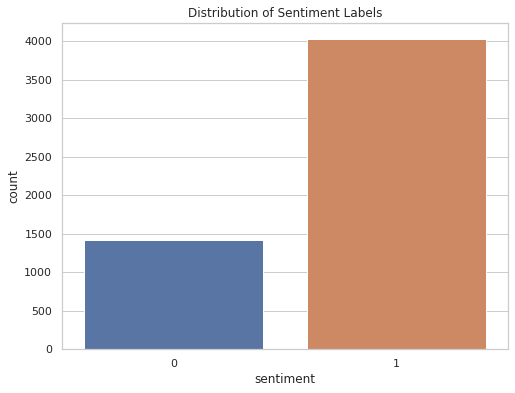

In [ ]:
# plot Distribution of Sentiment Labels, checking of imbalanced data
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data = data, x = 'sentiment')
ax.set_title('Distribution of Sentiment Labels')

In [5]:
# tokenise the cleaned text
data['cleaned_text_new'] = data['cleaned_text'].apply(lambda x: word_tokenize(x))

## Word2Vec + Neural Networks (ANN and LSTM)

From the Test Precision-Recall curve, we are able to derive that LSTM performs better than NN.

In [6]:
# Train the CBOW architecture
w2v_model1 = gensim.models.Word2Vec(data['cleaned_text_new'], vector_size=100, window=5, min_count=2, sg =0)

In [7]:
# Represents all of the words that our Word2Vec model learned a vector for (i.e all of the words that appeared in the training data at least twice)
w2v_model1.wv.index_to_key[0:20]

['like',
 'taste',
 'good',
 'great',
 'product',
 'would',
 'flavor',
 'one',
 'coffee',
 'love',
 'price',
 'really',
 'tea',
 'much',
 'get',
 'amazon',
 'food',
 'buy',
 'even',
 'use']

In [8]:
tok = Tokenizer()
tok.fit_on_texts(data['cleaned_text'])

# number of unique text in the data
vocab_size = len(tok.word_index) + 1
print('There are {} unique text in the data.'.format(vocab_size))

There are 12339 unique text in the data.


In [9]:
# find the maximum length in each record
maxi=-1
for i,rev in enumerate(data['cleaned_text']):
    tokens = rev.split()
    if(len(tokens) > maxi):
        maxi = len(tokens)
print('The maximum length of the review for each record in the data is {}.'.format(maxi))

# max length of a review
max_rev_len = maxi + 1 

# embedding dimension as choosen in word2vec constructor
embed_dim=100 

The maximum length of the review for each record in the data is 940.


In [10]:
# this converts texts into some numeric sequences 
encd_rev = tok.texts_to_sequences(data['cleaned_text'])

# we dont pad to a maximum length of 925 but use 50 if not the train data will be very sparse
pad_rev= pad_sequences(encd_rev, maxlen = 50, padding = 'post')
pad_rev.shape  

(5444, 50)

In [11]:
# now creating the embedding matrix
embed_matrix=np.zeros(shape = (vocab_size, embed_dim))
for word, i in tok.word_index.items():

  # check if word is in the vocabulary learned by the w2v model
  if word in w2v_model1.wv.index_to_key:  
    # get the word vector from w2v model
    embed_matrix[i] = w2v_model1.wv[word]
  # else the embed_vector corressponding to that vector will stay zero.

In [ ]:
embed_matrix.shape

(12339, 100)

In [12]:
# one hot target as required by NN.
Y=keras.utils.to_categorical(data['sentiment']) 
X_train, X_test, y_train, y_test = train_test_split(pad_rev, Y, test_size = 0.20, random_state = 11)

### NN

In [21]:
# Build the NN Model
model=Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embed_dim, 
                    input_length = 50, weights=[embed_matrix])) # embeddings_initializer = Constant(embed_matrix)))

model.add(Flatten())
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.50))
# model.add(Dense(16,activation = 'relu'))
# model.add(Dropout(0.20))
model.add(Dense(2, activation = 'sigmoid')) 
#model.add(Dense(2, activation = 'softmax'))

In [22]:
model.compile(optimizer='adam', metrics=['acc'],  loss='binary_crossentropy')

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1233900   
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 16)                80016     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1,313,950
Trainable params: 1,313,950
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# Run NN 

start = time.time()
history_embedding = model.fit(X_train, y_train, epochs=15, batch_size = 64, validation_data = (X_test, y_test)) 

end = time.time()
print("Time taken to run model: {} seconds.".format(end - start))

Epoch 1/15
69/69 [==============================] - 3s 26ms/step - loss: 0.5890 - acc: 0.7366 - val_loss: 0.5526 - val_acc: 0.7300
Epoch 2/15
69/69 [==============================] - 2s 30ms/step - loss: 0.5586 - acc: 0.7428 - val_loss: 0.5380 - val_acc: 0.7300
Epoch 3/15
69/69 [==============================] - 2s 31ms/step - loss: 0.5106 - acc: 0.7428 - val_loss: 0.4929 - val_acc: 0.7300
Epoch 4/15
69/69 [==============================] - 2s 24ms/step - loss: 0.4451 - acc: 0.7428 - val_loss: 0.4369 - val_acc: 0.7300
Epoch 5/15
69/69 [==============================] - 1s 21ms/step - loss: 0.3688 - acc: 0.7428 - val_loss: 0.4237 - val_acc: 0.7300
Epoch 6/15
69/69 [==============================] - 1s 21ms/step - loss: 0.3020 - acc: 0.7968 - val_loss: 0.3939 - val_acc: 0.8145
Epoch 7/15
69/69 [==============================] - 2s 30ms/step - loss: 0.2598 - acc: 0.9164 - val_loss: 0.4280 - val_acc: 0.8072
Epoch 8/15
69/69 [==============================] - 3s 40ms/step - loss: 0.2238 - a

In [24]:
# predict the response on the test data
NN_y_pred = model.predict(X_test) 

# get the predicted test response
NN_test_pred = []
for pred in NN_y_pred:
  if pred[0] >= 0.5:
    NN_test_pred.append(0)
  else:
    NN_test_pred.append(1)


# get actual test response
test_actual = []
for pred in y_test:
  if pred[0] >= 0.5:
    test_actual.append(0)
  else:
    test_actual.append(1)

35/35 [==============================] - 0s 3ms/step


In [25]:
# classification report for NN
print(classification_report(test_actual, NN_test_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.88      0.46      0.61       294
           1       0.83      0.98      0.90       795

    accuracy                           0.84      1089
   macro avg       0.85      0.72      0.75      1089
weighted avg       0.84      0.84      0.82      1089



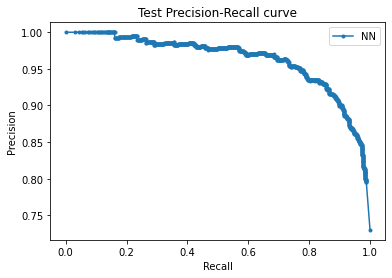

In [30]:
# keep probabilities for the positive outcome only
NN_y_probs = NN_y_pred[:, 1]

# plot the Test Precision-Recall curve
NN_precision, NN_recall, thresholds = precision_recall_curve(test_actual, NN_y_probs)
plt.plot(NN_recall, NN_precision,  marker='.', label = "NN")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Test Precision-Recall curve");

In [31]:
auc(NN_recall, NN_precision)

0.9626273469640907

In [32]:
average_precision_score(test_actual, NN_y_probs)

0.9622482952514285

### LSTM

In [ ]:
# Build the LSTM Model
model=Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embed_dim, 
                    input_length = 50, weights=[embed_matrix])) # embeddings_initializer = Constant(embed_matrix)))
model.add(LSTM(128))
model.add(Flatten())
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.20))
model.add(Dense(2, activation='sigmoid'))

In [ ]:
# compile the model
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 5e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

file_path = '/content/gdrive/MyDrive/Colab Notebooks/DSA4263 Project/LSTM220323.h5'

checkpoint = ModelCheckpoint(
    file_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"
)

# reduce_on_plateau = ReduceLROnPlateau(
#     monitor="val_accuracy", factor=0.1, patience=2, verbose=1, min_delta=1e-2
# )

early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, verbose=2, min_delta=1e-2
)

callbacks_list = [checkpoint, early_stopping]

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 100)           1233900   
                                                                 
 lstm_7 (LSTM)               (None, 128)               117248    
                                                                 
 flatten_8 (Flatten)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 16)                2064      
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 2)                 34        
                                                                 
Total params: 1,353,246
Trainable params: 1,353,246
No

In [ ]:
# learning rate 5e-4
# fitting the LSTM model

start = time.time()
history_embedding = model.fit(X_train, y_train, epochs=15, batch_size = 64, validation_data = (X_test, y_test), callbacks = callbacks_list)

end = time.time()
print("Time taken to run model: {} seconds.".format(end - start))

Epoch 1/15
68/69 [============================>.] - ETA: 0s - loss: 0.5856 - accuracy: 0.7364
Epoch 1: val_accuracy improved from -inf to 0.73003, saving model to /content/gdrive/MyDrive/Colab Notebooks/LSTM220323.h5
69/69 [==============================] - 16s 189ms/step - loss: 0.5855 - accuracy: 0.7364 - val_loss: 0.6026 - val_accuracy: 0.7300
Epoch 2/15
69/69 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.7431
Epoch 2: val_accuracy improved from 0.73003 to 0.73554, saving model to /content/gdrive/MyDrive/Colab Notebooks/LSTM220323.h5
69/69 [==============================] - 12s 180ms/step - loss: 0.5631 - accuracy: 0.7431 - val_loss: 0.6166 - val_accuracy: 0.7355
Epoch 3/15
68/69 [============================>.] - ETA: 0s - loss: 0.5119 - accuracy: 0.7716
Epoch 3: val_accuracy improved from 0.73554 to 0.82461, saving model to /content/gdrive/MyDrive/Colab Notebooks/LSTM220323.h5
69/69 [==============================] - 10s 149ms/step - loss: 0.5118 - accura

In [13]:
# use the best model
file_path = '/content/gdrive/MyDrive/Colab Notebooks/DSA4263 Project/LSTM220323.h5'
new_model = load_model(file_path)

In [14]:
# predict the response on the test data
LSTM_y_pred = new_model.predict(X_test) 

# get the predicted test response
LSTM_test_pred = []
for pred in LSTM_y_pred:
  if pred[0] >= 0.5:
    LSTM_test_pred.append(0)
  else:
    LSTM_test_pred.append(1)


# get actual test response
test_actual = []
for pred in y_test:
  if pred[0] >= 0.5:
    test_actual.append(0)
  else:
    test_actual.append(1)

35/35 [==============================] - 5s 57ms/step


In [15]:
# classification report for NN
print(classification_report(test_actual, LSTM_test_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.86      0.68      0.76       294
           1       0.89      0.96      0.92       795

    accuracy                           0.88      1089
   macro avg       0.88      0.82      0.84      1089
weighted avg       0.88      0.88      0.88      1089



In [17]:
LSTM_y_probs = LSTM_y_pred[:, 1]
LSTM_precision, LSTM_recall, LSTM_thresholds = precision_recall_curve(test_actual, LSTM_y_probs)

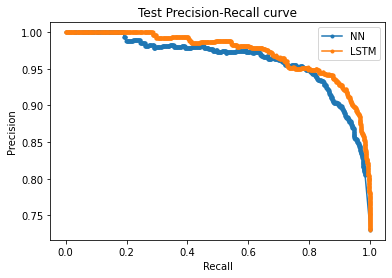

In [ ]:
# keep probabilities for the positive outcome only
NN_y_probs = NN_y_pred[:, 1]
LSTM_y_probs = LSTM_y_pred[:, 1]

# plot the Test Precision-Recall curve
NN_precision, NN_recall, NN_thresholds = precision_recall_curve(test_actual, NN_y_probs)
LSTM_precision, LSTM_recall, LSTM_thresholds = precision_recall_curve(test_actual, LSTM_y_probs)
plt.plot(NN_recall, NN_precision,  marker='.', label = "NN")
plt.plot(LSTM_recall, LSTM_precision,  marker='.', label = "LSTM")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Test Precision-Recall curve");

In [18]:
auc(LSTM_recall, LSTM_precision)

0.9719919741025463

In [20]:
average_precision_score(test_actual, LSTM_y_probs)

0.9720141764716924